In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision
import os
import torchvision.datasets as dset
from torchvision import transforms, models
from glob import glob
from tqdm import tqdm
import torch.nn.functional as F
from PIL import Image, ImageFile
import numpy as np
import cv2

/home/howeng/anaconda3/envs/AD/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
EPOCHS = 5
BATCH_SIZE = 1
BOARD_SIZE= 19
TEST_SAMPLES = './data/frame555.jpg'

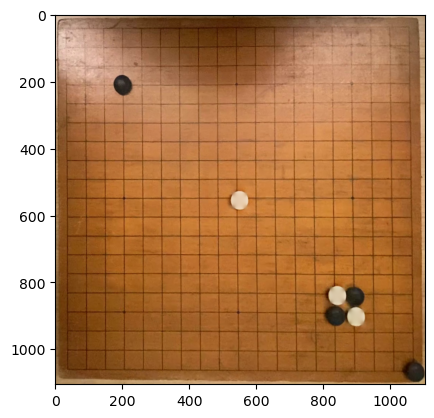

In [14]:
def read_and_preprocess_img(IMG_PATH):
    
    img = cv2.imread(IMG_PATH)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # 先轉成灰階處理
    ret, thresh = cv2.threshold(img_gray, 200, 255, 0)  # 利用 threshold 過濾出高光的部分，目前設定高於 200 即為高光
    contours, hierarchy  = cv2.findContours(thresh.copy(),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    img_zero = np.zeros(img.shape, dtype=np.uint8) 
    
#     print(len(contours))

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour) 
        img_zero[y:y+h, x:x+w] = 255 
        mask = img_zero     
    
    # alpha，beta 共同決定高光消除後的模糊程度
    # alpha: 亮度的缩放因子，默認是 0.2， 範圍[0, 2], 值越大，亮度越低
    # beta:  亮度缩放後加上的参数，默認是 0.4， 範圍[0, 2]，值越大，亮度越低
    result = cv2.illuminationChange(img, mask, alpha=0.2, beta=0.4) 
    
    pts1 = np.float32([(513,55),(583,1040),(1603,57),(1554,981)])
    pts2 = np.float32([(0,0), (0,1100), (1100,10), (1100,1100)])
    m = cv2.getPerspectiveTransform(pts1, pts2) 
    fixed_rgb_img = cv2.warpPerspective(result, m, (1105, 1105))
    return fixed_rgb_img

res = read_and_preprocess_img('./data/frame1030.jpg')
plt.imshow(res)

In [11]:
LABELS = {
    './training_data/frame6.jpg': [
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    ],
    './training_data/frame15.jpg': [
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    ],
    './training_data/frame30.jpg': [
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    ],
    './training_data/frame243.jpg': [
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    ],
    './training_data/frame250.jpg': [
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    ],
    './training_data/frame320.jpg': [
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    ],
    './training_data/frame392.jpg': [
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    ],
    './training_data/frame555.jpg': [
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    ],
    './training_data/frame687.jpg': [
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    ],
    './training_data/frame760.jpg': [
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    ],
    './training_data/frame821.jpg': [
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    ],
    './training_data/frame971.jpg': [
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2],
    ],
    './training_data/frame1000.jpg': [
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2],
    ],    
    './training_data/frame1035.jpg': [
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2],
    ],
    TEST_SAMPLES : [
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2],
    ],
}

In [5]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path, input_size=256, is_train=True, s=1.0):
        
        self.image_transform = transforms.Compose(
            [
                transforms.ToPILImage(),
                transforms.Resize((input_size, input_size)),
                transforms.RandomHorizontalFlip(p=0.3),
                transforms.RandomVerticalFlip(p=0.3),
                transforms.RandomApply([transforms.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)], p=0.8),
                transforms.RandomGrayscale(p=0.3),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ]
        )
        
        self.image_files = glob(os.path.join('./training_data/', '*.jpg'))
        self.test_image = TEST_SAMPLES
        self.is_train = is_train
    
    def __getitem__(self, index):
        if self.is_train:
            image_file = self.image_files[index]            
        else:
            image_file = self.test_image
        
        x = read_and_preprocess_img(image_file)
        x = self.image_transform(x)         
        y = torch.as_tensor(LABELS[image_file])
        y = F.one_hot(y, num_classes=3)
        
        return x, y

    def __len__(self):
        return len(self.image_files)


In [6]:
class ModifiedNet(nn.Module):
    def __init__(self, num_class=3):
        super(ModifiedNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(131072, 19*19*num_class)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.dropout(x)
        x = torch.flatten(x)
        x = torch.relu(x)
        x = self.fc(x)
        x = torch.sigmoid(x)
        # x = torch.relu(x)
        output = x.reshape((19,19,3))
        return output


In [7]:
train_dataset = MyDataset(dataset_path='./training_data/', is_train=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

model = ModifiedNet()
# model = models.resnet18(pretrained=True)
# model.fc = nn.Sequential(
#     nn.Linear(512, 19*19*3),    
# )
model = model.cuda()

optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.5)
criterion = torch.nn.MSELoss()

model.train()
for epoch in range(EPOCHS):
    for x, y in tqdm(train_loader):
        x = x.cuda()
        y = y.cuda().float()
        outputs = model(x)  

        loss = criterion(outputs, y[0])
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print("Epoch:{} | Loss:{}".format(epoch, loss))

100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


Epoch:0 | Loss:0.021814687177538872


100%|██████████| 14/14 [00:09<00:00,  1.49it/s]


Epoch:1 | Loss:0.0013356802519410849


100%|██████████| 14/14 [00:09<00:00,  1.49it/s]


Epoch:2 | Loss:0.012147240340709686


100%|██████████| 14/14 [00:09<00:00,  1.49it/s]


Epoch:3 | Loss:0.00978183001279831


100%|██████████| 14/14 [00:09<00:00,  1.49it/s]

Epoch:4 | Loss:0.003595121204853058


In [12]:
def softmax_result(outputs):
    res_matrix = []
    for row in range(19):
        for col in range(19):
            ans = np.argmax(outputs[row,col])
            res_matrix.append(ans)
    return res_matrix

TEST_SAMPLES = './data/frame1000.jpg'
test_dataset = MyDataset(dataset_path='./training_data/', is_train=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

model.eval()
with torch.no_grad():
    for x,y in test_loader:
        x = x.cuda()                
        res = model(x)
print(res.shape)
print(res[0][0])
res_matrix = softmax_result(res.cpu().numpy())

torch.Size([19, 19, 3])
tensor([9.9978e-01, 9.1740e-05, 1.6131e-04], device='cuda:0')


In [13]:
for i in range(19*19):
    if i % 19 == 0:
        print('')
    print(res_matrix[i-1], end='')


0000000000000000000
0000000000000000000
0000000000000000000
0000200000000000000
0000000000000000000
0000000000000000000
0000000000000000000
0000000000000000000
0000000000000000000
0000000000000000000
0000000000000000000
0000000000000000000
0000000000000000000
0000000000000000000
0000000000000000000
0000000000000002100
0000000000000000000
0000000000000000000
0000000000000000000